# DC v2

Perform more MDAC sweeps measuring with the lockin.

In [2]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [3]:
# Automagically reload modules when they are edited
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qcodes import Station, Instrument
from scipy.signal import find_peaks
from tqdm.notebook import tqdm

from monty import Monty
from liveplot import LivePlot, LiveContourPlot
import feedback
import swiper
import MDAC
from fridge import Fridge

# Import the neighbouring files. In may/
import may.dots as dots
from september.retort import Retort

from may.custom_devices import connect_to_gb, newSiDot, link_j_on_gb
from qcodes.instrument_drivers.stanford_research.SR860 import SR860

In [5]:
##%% Connect to instruments
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("lockin")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name lockin. Does not exist")

#scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')
#lockin = scfg.load_instrument('sr860_top')
#psg = scfg.load_instrument('PSG')

lockin = SR860('lockin', 'TCPIP::192.168.0.142::inst0::INSTR')
#lockin = SR860('lockin', 'TCPIP::192.168.0.108::inst0::INSTR')

#psg = E8267('psg', 'TCPIP0::192.168.0.109::inst0::INSTR')


gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.25s
Cannot remove instrument with name lockin. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.16s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [6]:
# Disconnect from all devices
disconnect = False
if disconnect:
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("lockin")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name lockin. Does not exist")
    try:
        psg = Instrument.find_instrument("psg")
        psg.close()
    except KeyError:
        print('Attempting to remove instrument with name psg. Does not exist')

In [7]:
experiment = {
    "desc": "Measure detuning using RF and DC methods"
}

monty = Monty("dc.diamonds2", experiment)

[2024-09-19 15:25:45,977] INFO Loading existing experiment (ignoring given experiment parameters)
[2024-09-19 15:25:45,997] WARNING Note that no experimental data has been loaded.
[2024-09-19 15:25:45,997] INFO Next run will have id 7


In [11]:
si.SETB(0)

In [70]:
dots.get_all_voltages(mdac)

LCB:   0.150004 V
RCB:   0.150003 V
RG:    2.000002 V
ResB:  1.799996 V
P3:    1.800002 V
P2:    1.400002 V
P1:    1.4 V
SETB:  0.0 V
SRB:   0.900001 V
SLB:   0.899997 V
ST:    3.700005 V
bias:  0.015002 V
VSS1P8:      0.0 V
VSS1P0:      0.0 V
VDD1P8:      1.800005 V
VDD1P0:      0.999996 V
VDD1P8_ANA:  1.8 V
BGN1P0:      0.0 V
BGN1P8:      0.0 V
BGP1P0:      0.0 V
BGP1P8:      0.0 V
RST:         1.799996 V
MOSI:        0.0 V
SCLK:        0.0 V
SS_N:        1.8 V
APBCLK:      0.0 V
VICL:        3.849995 V
VLFG:        0.0 V
VHFG:        0.0 V


In [68]:
si.ST()

3.700005

## Coulomb SET sweep (1D)

[2024-09-24 13:36:01,125] INFO Started new run SET_ST_sweep.10
Sweeping Si28_quantum_dot_ST from 2.5V to 3.0V in 401 points.


  0%|          | 0/401 [00:00<?, ?it/s]

[2024-09-24 13:38:56,843] INFO Run finished and took 0:02:55.718019.
[2024-09-24 13:38:56,844] INFO Saving to SET_ST_sweep.10.xz
[2024-09-24 13:38:56,859] INFO Saving to experiment.yaml


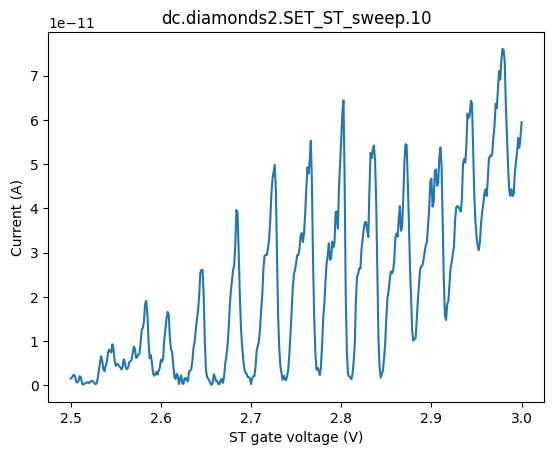

In [73]:
low = 2.5
high = 3.0
pts = 401

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty) 

monty.save(result)

## Feedback Functions

Restructure how we do feedback. Make a class that controls everything

In [77]:
retort = Retort(
    target=3e-11,
    stepsize=5e-4,
    slope="down",  # usually "up"
    bounds=(2.7, 3.0),
)

In [75]:
si.ST(2.81) # 3.6

In [79]:
retort.get_to_target(si, lockin)

In [ ]:
retort.move_with_feedback(si, lockin, si.SETB, end=0.00, dx=0.001)

In [ ]:
si.SETB()

In [80]:
si.ST()

2.800864

In [ ]:
np.arange(10, 5-1, -1)

## Sweep Antidetuning vs setb (2D)

In [ ]:
def sweep_anti_detuning_vs_setb(p_points, setb_points):
    """Measure electrons entering and exiting the double dot. Note the asymmetry when loading/unload the dots. Find a region of SETB where it is similar."""
    p_low, p_high, p_pts = p_points
    setb_low, setb_high, setb_pts = setb_points
    parameters = {
        "desc": "Sweep anti detuning axis (P1 + P2) (feedback)",
        "lockin_amplitude": f"Set to {lockin.amplitude()} V (with divider)",
        "ST":   f"Fixed at {si.ST()}V (target of {retort.target} on lockin, stepsize = {retort.stepsize})",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V",
        "P1": f"Ranged from {p_low}V -> {p_high}V in {p_pts} points",
        "P2": f"Ranged from {p_low}V -> {p_high}V in {p_pts} points",
        "SETB": f"Ranged from {setb_low} -> {setb_high} in {setb_pts} points",
        "temp": f"Mixing chamber {fridge.temp()} K",
        }
    
    monty.newrun("anti detuning loading", parameters)
    
    # gate voltage
    p_range = np.linspace(p_low, p_high, p_pts)
    setb_range = np.linspace(setb_low, setb_high, setb_pts)
    
    X = np.zeros((setb_pts, p_pts))
    Y = np.zeros((setb_pts, p_pts))
    R = np.zeros((setb_pts, p_pts))
    P = np.zeros((setb_pts, p_pts))
    ST_drift = np.zeros((setb_pts, p_pts))
    
    I = np.arange(p_pts)  # indices for datapoints
    
    with tqdm(total=setb_pts*p_pts) as pbar, LiveContourPlot(p_range, setb_range, xlabel="Antidetuning (V)", ylabel="SETB (V)") as lplot:
        for (j, setb) in enumerate(setb_range):
            
            # Set the new barrier gate
            retort.move_with_feedback(si, lockin, si.SETB, end=setb, dx=0.001, progress=False)
            #si.SETB(setb)
            
            time.sleep(1.0)  # ALlow any transitions to occur now
            
            for i in I:
                p = p_range[i]
                si.P1(p)
                si.P2(p)
                time.sleep(0.3)
                
                X[j, i] = lockin.X()
                Y[j, i] = lockin.Y()
                R[j, i] = lockin.R()
                P[j, i] = lockin.P()
                ST_drift[j, i] = si.ST()
                
                pbar.update(1)
                lplot.update(R)
                
                retort.feedback(si, lockin)
                
            monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST_drift": ST_drift})
            I = I[::-1]  # flip the next direction
            
    monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})
    
    swiper.plotsweep2d(setb_range, p_range, R, "SETB", "Antidetuning", monty)  # note wont separate directions
    swiper.plotsweep2d(setb_range[::2], p_range, R[::2, :], "SETB", "Antidetuning", extra_title=".forward", monty=monty)
    swiper.plotsweep2d(setb_range[1::2], p_range, R[1::2, :], "SETB", "Antidetuning", extra_title=".backward", monty=monty)

    return {"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}
    

In [ ]:
print(f"ST = {si.ST()}\nSLB = {si.SLB()}\nSRB = {si.SRB()}")
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nSETB = {si.SETB()}")

In [ ]:
# Unload any electrons
si.P1(1.0)
si.P2(1.0)
time.sleep(5)

In [ ]:
si.ST(3.366515)

In [ ]:
retort.get_to_target(si, lockin, progress=True)

In [ ]:
0.2/51

In [ ]:
p_low = 1.3
p_high = 1.6
p_pts = 301

setb_low = 0.4
setb_high = 0.2
setb_pts = 151

# Setup gates correctly
retort.move_with_feedback(si, lockin, si.P1, end=p_low)
retort.move_with_feedback(si, lockin, si.P2, end=p_low)
retort.move_with_feedback(si, lockin, si.SETB, end=setb_low)
time.sleep(5)

# Get to SET target
retort.get_to_target(si, lockin)
time.sleep(1)

result = sweep_anti_detuning_vs_setb((p_low, p_high, p_pts), (setb_low, setb_high, setb_pts))

## Sweep detuning or antidetuning (1D)

In [ ]:
def two_gate_sweep(g1_params, g2_params, pts):
    g1, g1_low, g1_high = g1_params
    g2, g2_low, g2_high = g2_params
    
    parameters = {
        "desc": "Sweep detuning axis (P1 - P2) (feedback)",
        "lockin_amplitude": "Set to 10uV",
        "ST":   f"Fixed at {si.ST()}V (target of {retort.target} on lockin, stepsize = {retort.stepsize})",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "SETB": f"Fixed at {si.SETB()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V",
        g1.name: f"Ranged from {g1_low}V -> {g1_high}V in {pts} points",  # P1 or P2
        g2.name: f"Ranged from {g2_low}V -> {g2_high}V in {pts} points",  # P1 or P2
        "temp": f"Mixing chamber {fridge.temp()} K",
        }
    
    monty.newrun(f"{g1.name} vs {g2.name} scan", parameters)
    
    # gate voltages
    g1_range = np.linspace(g1_low, g1_high, pts)
    g2_range = np.linspace(g2_low, g2_high, pts)
    I = np.arange(pts)
    
    X = np.zeros((pts))
    Y = np.zeros((pts))
    R = np.zeros((pts))
    P = np.zeros((pts))
    ST_drift = np.zeros(pts)
    
    with tqdm(total=pts) as pbar, LivePlot(g1_range, xlabel=f"{g1.name} V", ylabel="Current (A)") as lplot:
        for i in I:
            g1(g1_range[i])
            g2(g2_range[i])
            time.sleep(0.5)
            
            ST_drift[i] = si.ST()
            X[i] = lockin.X()
            Y[i] = lockin.Y()
            R[i] = lockin.R()
            P[i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            retort.feedback(si, lockin)
    
    monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})

    return {"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}

In [ ]:
def plot_detuning(g1_params, g2_params, R, ST_drift):
    """Plot the detuning axis plot"""
    g1, g1_low, g1_high = g1_params
    g2, g2_low, g2_high = g2_params
    
    R = result["R"]
    ST_drift = result["ST"]
    
    detuning = np.linspace((g1_low-g2_low)/np.sqrt(2), (g1_high-g2_high)/np.sqrt(2), len(R))
    
    fig, ax0 = plt.subplots()
    ax1 = ax0.twinx()
    
    ax0.plot(detuning, R, "g-", label="Lockin")
    ax0.grid()
    ax0.set_ylabel("Lockin (A)", color="g")
    ax0.set_xlabel("Detuning (V)")
    
    # Plot ST history over time
    ax1.plot(detuning, ST_drift, "r-", label="ST gate")
    ax1.set_ylabel("ST voltage (V)", color="r")
    
    ax0.set_title(monty.identifier + "." + monty.runname)
    
    fig.tight_layout()
    monty.savefig(plt, "detuning")

In [ ]:
print(f"ST = {si.ST()}\nSLB = {si.SLB()}\nSRB = {si.SRB()}")
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nSETB = {si.SETB()}")
print(f"J = {gb_control_si.VICL()}\n")

In [ ]:
si.ST(3.332)

In [ ]:
retort.get_to_target(si, lockin)

In [ ]:
retort.move_with_feedback(si, lockin, si.SETB, end=0.34)

In [ ]:
for setb in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55][::-1]:
    retort.move_with_feedback(si, lockin, si.SETB, end=setb)
    
    g1_params = (si.P1, 1.3, 1.8)
    g2_params = (si.P2, 1.8, 1.3)
    
    pts = 401
    
    retort.move_with_feedback(si, lockin, g1_params[0], end=g1_params[1], progress=False)
    retort.move_with_feedback(si, lockin, g2_params[0], end=g2_params[1], progress=False)
    time.sleep(5)
    
    result = two_gate_sweep(g1_params, g2_params, pts)
    plot_detuning(g1_params, g2_params, result["R"], result["ST"])
    plt.show()

## Coulomb diamonds

In [59]:
# Coulomb diamond scan
def coulomb_diamond(st_params, bias_params):
    start_st, end_st, pts_st = st_params
    start_bias, end_bias, pts_bias = bias_params
    parameters = {
        "desc": "Sweep the SET keeping one reservoir fixed",
        "lockin_amplitude": "Set to 10uV",
        "ST":   f"Ranged from {start_st} to {end_st} in {pts_st} points",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "bias":  f"Ranged from {start_bias} to {end_bias} in {pts_bias} points",
        "SETB": f"Fixed at {si.SETB()}V",
        "temp": f"Mixing chamber {fridge.temp()} K",
        }
    
    monty.newrun("coulomb_diamond", parameters)
    
    # gate voltages
    st_range = np.linspace(start_st, end_st, pts_st)
    bias_range = np.linspace(start_bias, end_bias, pts_bias)
    
    X = np.zeros((pts_st, pts_bias))
    Y = np.zeros((pts_st, pts_bias))
    R = np.zeros((pts_st, pts_bias))
    P = np.zeros((pts_st, pts_bias))
    
    I = np.arange(pts_bias)  # indices for datapoints
    
    with tqdm(total=pts_bias*pts_st) as pbar, LiveContourPlot(bias_range, st_range, xlabel="Bias (V)", ylabel="ST (V)") as lplot:
        for (j, st) in enumerate(st_range):
            si.ST(st)
            time.sleep(0.4)
            
            for i in I:
                si.bias(bias_range[i])
                time.sleep(0.2)  # 0.3 minimum
                
                X[j, i] = lockin.X()
                Y[j, i] = lockin.Y()
                R[j, i] = lockin.R()
                P[j, i] = lockin.P()
                
                pbar.update(1)
                lplot.update(R)
                
            monty.snapshot({"X": X, "Y": Y, "R": R, "P": P})
            
            # Flip the direction of the next sweep
            I = I[::-1]
    
    monty.save({"X": X, "Y": Y, "R": R, "P": P})
    
    swiper.plotsweep2d(st_range, bias_range, R, "ST", "Bias", monty)  # note wont separate directions
    swiper.plotsweep2d(st_range[::2], bias_range, R[::2, :], "ST", "Bias", extra_title=".forward", monty=monty)
    swiper.plotsweep2d(st_range[1::2], bias_range, R[1::2, :], "ST", "Bias", extra_title=".backward", monty=monty)
    return R

In [48]:
print(f"ST = {si.ST()}\nSLB = {si.SLB()}\nSRB = {si.SRB()}")
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nSETB = {si.SETB()}")
print(f"J = {gb_control_si.VICL()}\n")

ST = 3.600002
SLB = 0.899997
SRB = 0.900001
P1 = 1.799998
P2 = 1.799997
SETB = 0.0
J = 3.8



In [49]:
si.bias(0)
si.P1(1.8)
si.P2(1.8)
gb_control_si.VICL(3.8)
si.SETB(0)

In [50]:
si.ST(3.6)

[2024-09-23 09:47:22,451] INFO Started new run coulomb_diamond


  0%|          | 0/2121 [00:00<?, ?it/s]

[2024-09-23 10:02:30,783] INFO Run finished and took 0:15:08.331537.
[2024-09-23 10:02:30,784] INFO Saving to coulomb_diamond.xz
[2024-09-23 10:02:30,815] INFO Saving to experiment.yaml


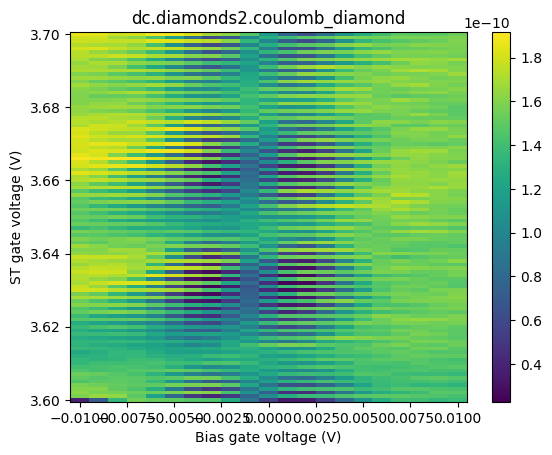

In [51]:
st_low = 3.6
st_high = 3.7
st_pts = 101

bias_low = -0.01
bias_high = 0.01
bias_pts = 21

result = coulomb_diamond((st_low, st_high, st_pts), (bias_low, bias_high, bias_pts))

## Charge stability (P1 vs P2) 2D

In [81]:
def sweep_charge_stablity_2d(p1_params, p2_params):
    """Measure electrons entering and exiting the double dot. Note the asymmetry when loading/unload the dots. Find a region of SETB where it is similar."""
    p1_low, p1_high, p1_pts = p1_params
    p2_low, p2_high, p2_pts = p2_params
    parameters = {
        "desc": "Sweep P1 vs P2 (with feedback)",
        "lockin_amplitude": f"Set to {lockin.amplitude()} V (with divider)",
        "ST":   f"Fixed at {si.ST()}V (target of {retort.target} on lockin, stepsize = {retort.stepsize})",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "ResB":  f"Fixed at {si.ResB()}V",
        "P3":  f"Fixed at {si.P3()}V",
        "RG":  f"Fixed at {si.RG()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V (linked with J2)",
        "P1": f"Ranged from {p1_low}V -> {p1_high}V in {p1_pts} points",
        "P2": f"Ranged from {p2_low}V -> {p2_high}V in {p2_pts} points",
        "SETB": f"Fixed at {si.SETB()}V",
        "temp": f"Mixing chamber {fridge.temp()} K",
        }
    
    monty.newrun("2d charge stability", parameters)
    
    # gate voltage
    p1_range = np.linspace(p1_low, p1_high, p1_pts)
    p2_range = np.linspace(p2_low, p2_high, p2_pts)
    
    X = np.zeros((p2_pts, p1_pts))
    Y = np.zeros((p2_pts, p1_pts))
    R = np.zeros((p2_pts, p1_pts))
    P = np.zeros((p2_pts, p1_pts))
    ST_drift = np.zeros((p2_pts, p1_pts))
    
    I = np.arange(p1_pts)  # indices for datapoints
    
    with tqdm(total=p1_pts*p2_pts) as pbar, LiveContourPlot(p1_range, p2_range, xlabel="P2 (V)", ylabel="P2 (V)") as lplot:
        for (j, p2) in enumerate(p2_range):
            
            # Set the new barrier gate
            #retort.move_with_feedback(si, lockin, si.SETB, end=setb, dx=0.001, progress=False)

            si.P2(p2)
            
            time.sleep(0.3)  # ALlow any transitions to occur now
            retort.feedback(si, lockin)
            
            for i in I:
                si.P1(p1_range[i])
                time.sleep(0.3)
                
                X[j, i] = lockin.X()
                Y[j, i] = lockin.Y()
                R[j, i] = lockin.R()
                P[j, i] = lockin.P()
                ST_drift[j, i] = si.ST()
                
                pbar.update(1)
                lplot.update(R)
                
                retort.feedback(si, lockin)
                
            monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST_drift": ST_drift})
            I = I[::-1]  # flip the next direction
            
    monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})
    
    swiper.plotsweep2d(p2_range, p1_range, R, "P2", "P1", monty)  # note wont separate directions
    swiper.plotsweep2d(p2_range[::2], p1_range, R[::2, :], "P2", "P1", extra_title=".forward", monty=monty)
    swiper.plotsweep2d(p2_range[1::2], p1_range, R[1::2, :], "P2", "P1", extra_title=".backward", monty=monty)

    return {"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}
    

In [88]:
print(f"ST = {si.ST()}\nSLB = {si.SLB()}\nSRB = {si.SRB()}")
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nSETB = {si.SETB()}")
print(f"J = {gb_control_si.VICL()}\n")

ST = 2.784103
SLB = 0.899997
SRB = 0.900001
P1 = 1.700003
P2 = 1.700003
SETB = 0.0
J = 3.909994



In [25]:
# Link J1 with J2
link_j_on_gb(mdac, gb_control_si)

Ramping J1 down to 0V
Coupling J1, J2 together
Ramping J1, J2 to loading values


In [64]:
gb_control_si.VICL(3.85)

In [29]:
# Raise other gates to reservoir
si.RG(2.0)
si.ResB(1.8)
si.P1(1.3)
si.P2(1.3)
si.P3(1.8)
gb_control_si.VICL(4.0)

In [9]:
si.ST(3.5369)

In [87]:
retort.tol /= 2
retort.get_to_target(si, lockin)
retort.tol *= 2

ST = 2.7841e+00, lockin = 3.1559e-11, delta = 1.2739e-12


In [86]:
retort.move_with_feedback(si, lockin, gb_control_si.VICL, end=3.9)

Target = 3.0000e-11, tol = 1e-11, initial ST = 2.786039
ST = 2.7851e+00, lockin = 2.1286e-11, delta = 8.5943e-12 delta = 1.4755e-11
ST = 2.7842e+00, lockin = 2.2506e-11, delta = 7.4347e-12 delta = 1.1641e-11
VICL = 3.8700e+00, ST = 2.7842e+00, lockin = 2.4802e-11, delta = 5.0660e-12
VICL = 3.8800e+00, ST = 2.7842e+00, lockin = 3.0364e-11, delta = 4.3845e-13
VICL = 3.8900e+00, ST = 2.7842e+00, lockin = 3.0888e-11, delta = 8.1406e-13
VICL = 3.9000e+00, ST = 2.7842e+00, lockin = 2.3653e-11, delta = 6.6380e-12
ST = 2.7837e+00, lockin = 2.0509e-11, delta = 9.2965e-12 delta = 1.2785e-11

Final ST = 2.78375


In [67]:
si.P1(1.4)
si.P2(1.4)

Target = 3.0000e-11, tol = 1e-11, initial ST = 2.784103
P1 = 1.7000e+00, ST = 2.7841e+00, lockin = 2.4329e-11, delta = 5.7135e-12
P1 = 1.6900e+00, ST = 2.7841e+00, lockin = 2.2890e-11, delta = 6.9780e-12

Final ST = 2.784103
Target = 3.0000e-11, tol = 1e-11, initial ST = 2.784103
P2 = 1.7000e+00, ST = 2.7841e+00, lockin = 3.5008e-11, delta = 5.2233e-12
ST = 2.7849e+00, lockin = 3.0996e-11, delta = 7.9073e-13elta = 1.1901e-11

Final ST = 2.784879

[2024-09-25 16:12:15,641] INFO Started new run 2d_charge_stability.7


  0%|          | 0/90601 [00:00<?, ?it/s]

[2024-09-26 17:39:18,871] INFO Run finished and took 1 day, 1:27:03.229568.
[2024-09-26 17:39:18,872] INFO Saving to 2d_charge_stability.7.xz
[2024-09-26 17:39:20,039] INFO Saving to experiment.yaml


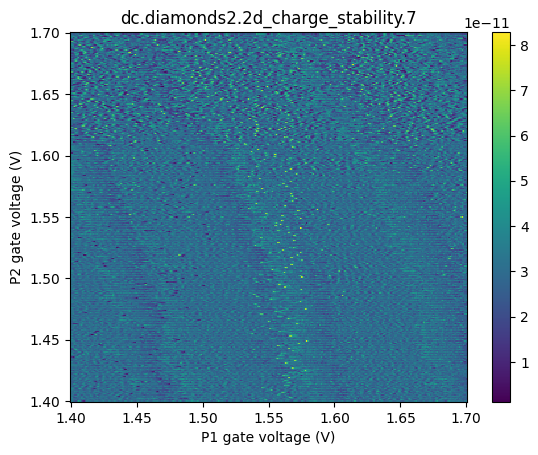

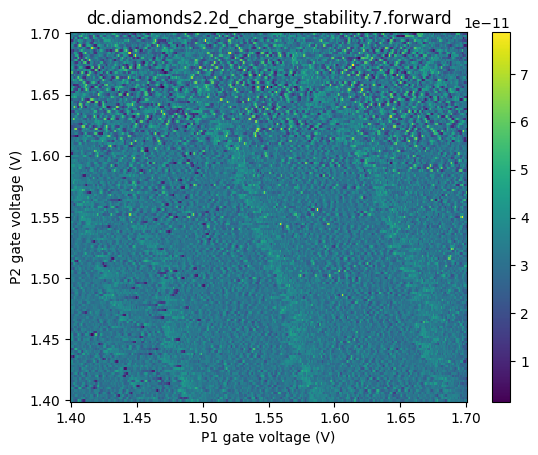

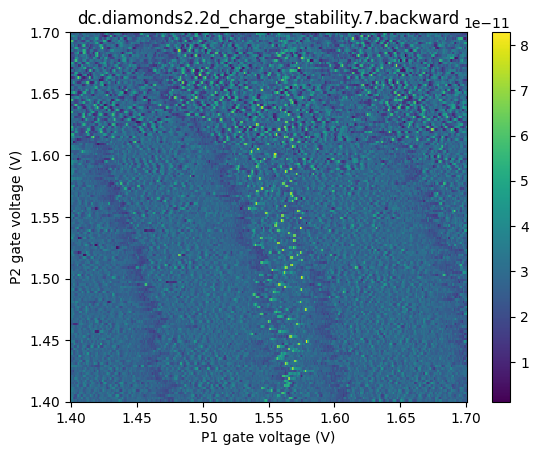

In [89]:
p1_low = 1.7
p1_high = 1.4
p1_pts = 301

p2_low = 1.7
p2_high = 1.4
p2_pts = 301

# Setup gates correctly
retort.move_with_feedback(si, lockin, si.P1, end=p1_low)
retort.move_with_feedback(si, lockin, si.P2, end=p2_low)
time.sleep(5)

# Get to SET target
retort.get_to_target(si, lockin)
time.sleep(1)

result = sweep_charge_stablity_2d((p1_low, p1_high, p1_pts), (p2_low, p2_high, p2_pts))

In [43]:
R = result["R"]

In [84]:
gb_control_si.VICL()

3.849995